In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
data = pd.read_csv('天然气（清洗）.csv',encoding='gb2312')
data.head()

,日期,收盘,开盘,高,低,涨跌幅,交易量
0,2022/3/1,4.573,4.408,4.627,4.340,3.88%,112.55
1,2022/3/2,4.762,4.600,4.911,4.600,4.13%,141.69
2,2022/3/3,4.722,4.795,4.936,4.628,-0.84%,137.15
3,2022/3/4,5.016,4.750,5.045,4.728,6.23%,125.39
4,2022/3/7,4.833,5.041,5.184,4.781,-3.65%,130.86


In [6]:
# 把日期类型转为datetime
data['日期'] = pd.to_datetime(data['日期'])

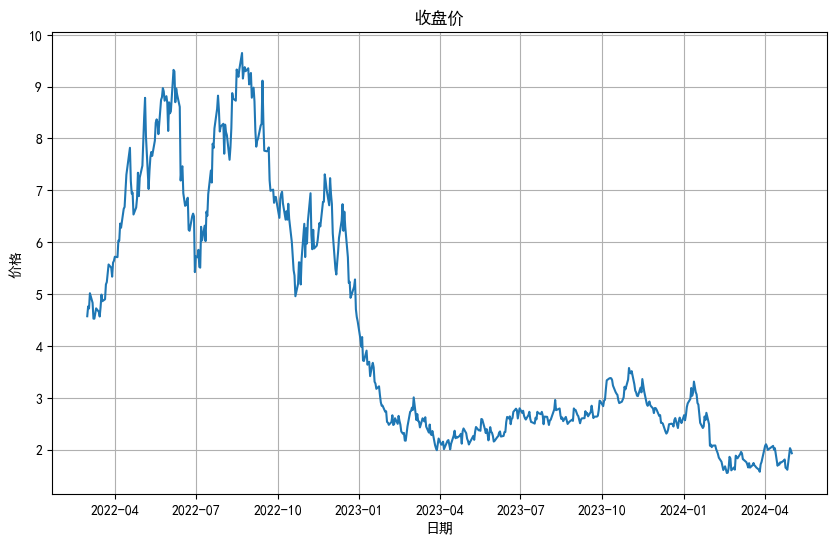

In [7]:
# 绘制收盘价的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(data['日期'], data['收盘'])
plt.title('收盘价')
plt.xlabel('日期')
plt.ylabel('价格')
plt.grid(True) 
plt.show()

In [8]:
# ADF检验函数
def adf_test(timeseries):
    # 进行Dickey-Fuller检验
    result = adfuller(timeseries)
    print('ADF 统计值: %f' % result[0])
    print('p值: %f' % result[1])
    print('临界值:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# 对收盘价进行ADF检验
adf_test(data['收盘'])

ADF 统计值: -0.965868
p值: 0.765509
临界值:
	1%: -3.442
	5%: -2.867
	10%: -2.569


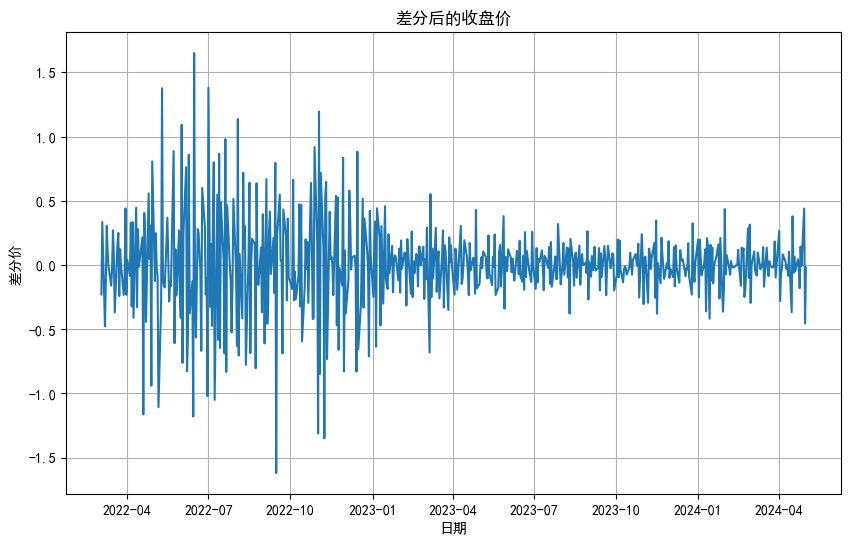

ADF 统计值: -8.741435
p值: 0.000000
临界值:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [13]:
# 对收盘价进行二阶差分
data_diff = data['收盘'].diff().diff().dropna()

# 绘制差分后的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(data['日期'][2:], data_diff)
plt.title('差分后的收盘价')
plt.xlabel('日期')
plt.ylabel('差分价')
plt.grid(True)
plt.show()

# 对差分后的数据进行ADF检验
adf_test(data_diff)

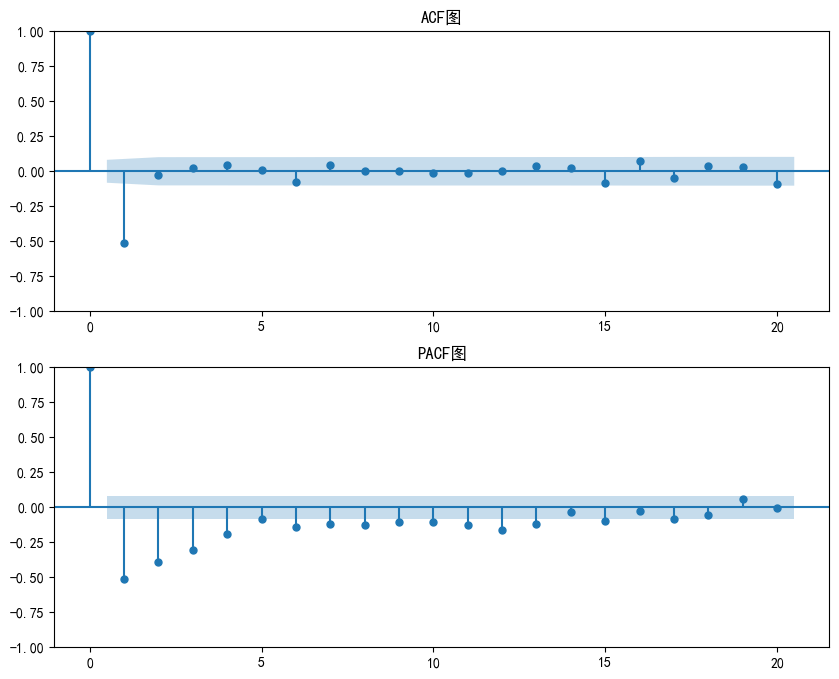

In [14]:
# 绘制ACF和PACF图
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data_diff, lags=20, ax=ax[0], title='ACF图')
plot_pacf(data_diff, lags=20, ax=ax[1], title='PACF图')
plt.show()

#### MA模型，q为1

In [15]:
# 拟合ARIMA模型
model = ARIMA(data['收盘'], order=(0,2,1)) # MA(2) 二阶差分
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     收盘   No. Observations:                  575
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  -3.528
Date:                Tue, 21 May 2024   AIC                             11.056
Time:                        00:11:04   BIC                             19.758
Sample:                             0   HQIC                            14.450
                                - 575                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      1.981     -0.505      0.614      -4.883       2.883
sigma2         0.0586      0.116      0.506      0.613      -0.168       0.286
===================================================================================
Ljung-Box (L1) (Q):                   2.33   Jarque-Bera (JB):               550.20
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

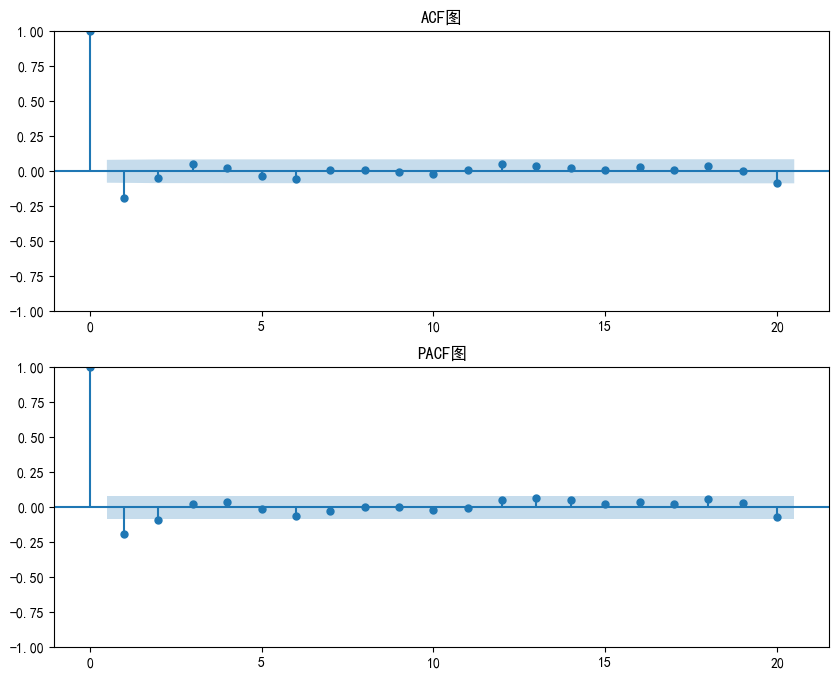

ADF 统计值: -36.462520
p值: 0.000000
临界值:
	1%: -3.442
	5%: -2.867
	10%: -2.569


In [16]:
# 残差分析
residuals = model_fit.resid

# 绘制残差的ACF和PACF图
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=20, ax=ax[0], title='ACF图')
plot_pacf(residuals, lags=20, ax=ax[1], title='PACF图')
plt.show()

# 残差的ADF检验
adf_test(residuals)

#### 可以看出，ACF截尾，PACF截尾，不存在明显的自相关性 
#### ADF统计值小于三个value，且p值为0，小于显著性水平则可以拒绝原假设，认为数据不存在单位根，数据是平稳的
#### 综上，可以说该拟合的时间序列模型是有效且可靠的